In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Load the dataset
data = pd.read_csv("/kaggle/input/house-price/1553768847-housing.csv")

# Display basic information about the dataset
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


In [3]:
# Drop rows with missing values
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  int64  
 3   total_rooms         20433 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  int64  
 6   households          20433 non-null  int64  
 7   median_income       20433 non-null  float64
 8   ocean_proximity     20433 non-null  object 
 9   median_house_value  20433 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.7+ MB


In [4]:
# Split the data into features and target variable
X = data.drop(['median_house_value'], axis=1)
y = data['median_house_value']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine the training data for preprocessing
train_data = x_train.join(y_train)

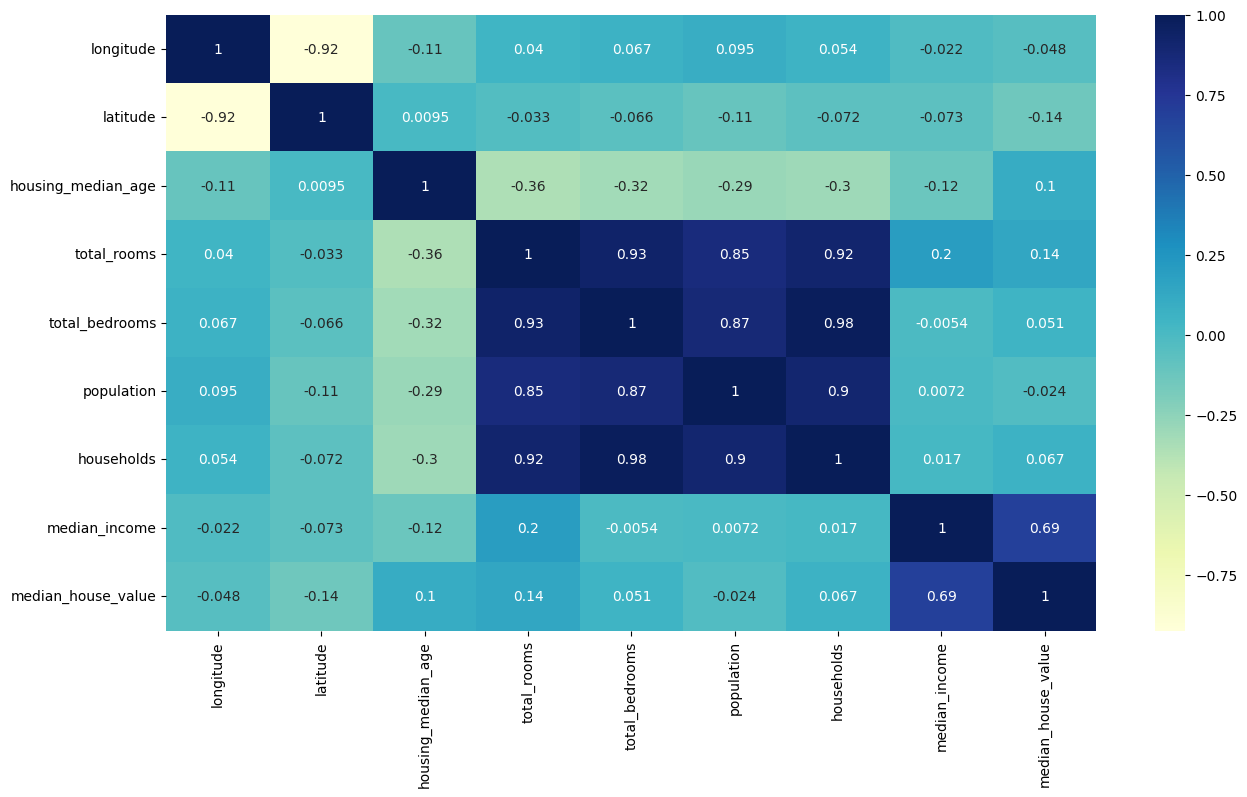

In [5]:
# Visualize correlations between numerical features
numeric_columns = train_data.select_dtypes(include=[np.number])
plt.figure(figsize=(15, 8))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [6]:
# Transform skewed data using log transformation
train_data['total_rooms'] = np.log(train_data['total_rooms'] + 1)
train_data['total_bedrooms'] = np.log(train_data['total_bedrooms'] + 1)
train_data['population'] = np.log(train_data['population'] + 1)
train_data['households'] = np.log(train_data['households'] + 1)

In [7]:
# One-hot encode the categorical feature 'ocean_proximity'
train_data = pd.get_dummies(train_data, columns=['ocean_proximity'], drop_first=True)


In [8]:
# Add new features for feature engineering
train_data['bedroom_ratio'] = train_data['total_bedrooms'] / train_data['total_rooms']
train_data['household_rooms'] = train_data['total_rooms'] / train_data['households']


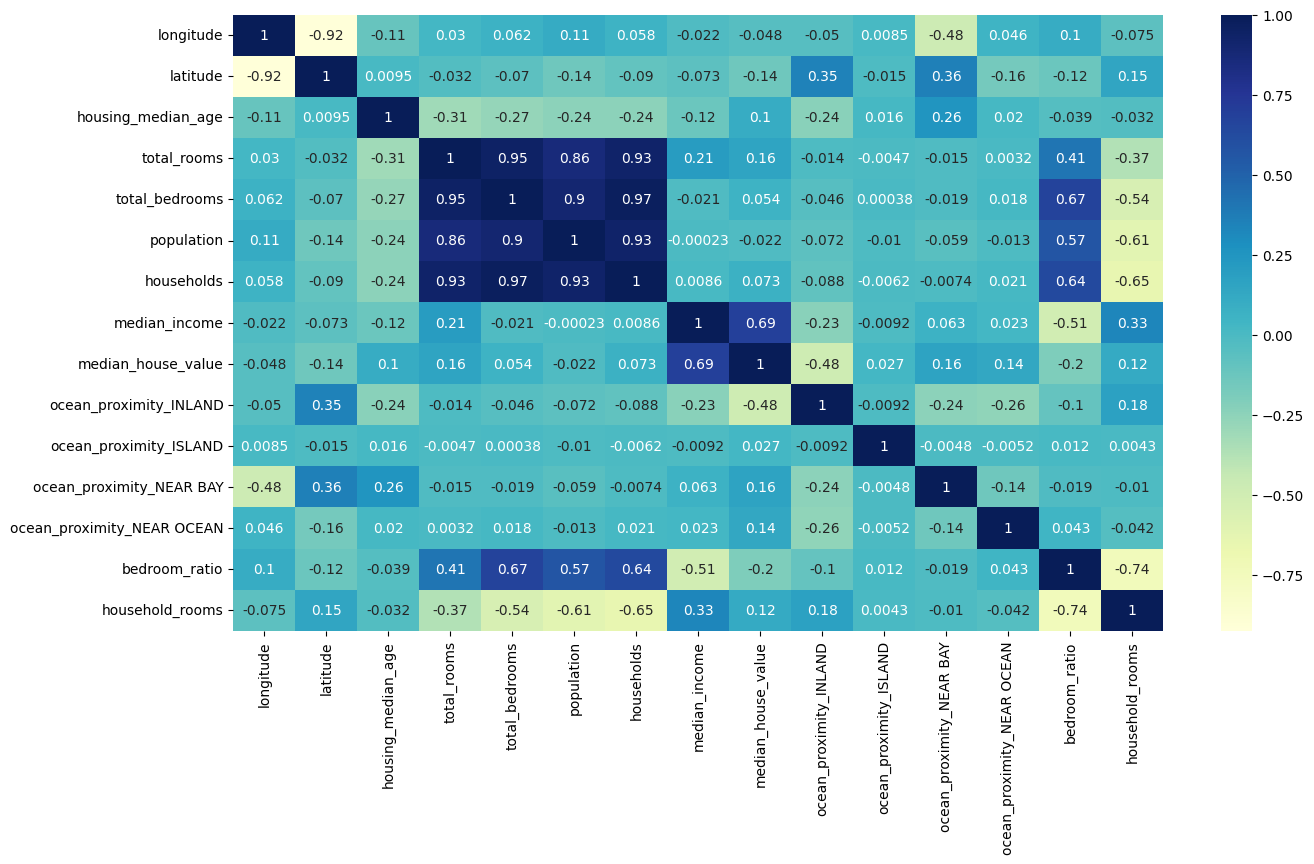

In [9]:
# Visualize the correlation matrix again after feature engineering
plt.figure(figsize=(15, 8))
sns.heatmap(train_data.corr(), annot=True, cmap='YlGnBu')
plt.show()


In [10]:
# Prepare the data for modeling
x_train = train_data.drop(['median_house_value'], axis=1)
y_train = train_data['median_house_value']


In [11]:
# Scale the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

In [12]:
# Train a Linear Regression model
reg = LinearRegression()
reg.fit(x_train_scaled, y_train)

LinearRegression()

In [13]:
# Prepare the test data for prediction
x_test['total_rooms'] = np.log(x_test['total_rooms'] + 1)
x_test['total_bedrooms'] = np.log(x_test['total_bedrooms'] + 1)
x_test['population'] = np.log(x_test['population'] + 1)
x_test['households'] = np.log(x_test['households'] + 1)
x_test = pd.get_dummies(x_test, columns=['ocean_proximity'], drop_first=True)


In [14]:
# Add new features to the test data
x_test['bedroom_ratio'] = x_test['total_bedrooms'] / x_test['total_rooms']
x_test['household_rooms'] = x_test['total_rooms'] / x_test['households']

# Align the test data with the training data (in case of missing columns after one-hot encoding)
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)


In [15]:
# Scale the test data
x_test_scaled = scaler.transform(x_test)

In [16]:
# Evaluate the Linear Regression model
print("Linear Regression score:", reg.score(x_test_scaled, y_test))


Linear Regression score: 0.6687407117584969


In [17]:
# Train a Random Forest Regressor
forest = RandomForestRegressor()
forest.fit(x_train_scaled, y_train)

# Evaluate the Random Forest model
print("Random Forest score:", forest.score(x_test_scaled, y_test))

Random Forest score: 0.8198741216265508


In [18]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [30, 50, 100],
    'max_features': [8, 12, 20],
    'min_samples_split': [2, 4, 6, 8]
}

grid_search = GridSearchCV(forest, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [8, 12, 20],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [30, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [20]:
# Evaluate the best model found by GridSearchCV
best_forest = grid_search.best_estimator_
print("Best Random Forest score:", best_forest.score(x_test_scaled, y_test))


Best Random Forest score: 0.823237997151739


    Actual      Predicted
0   245800  237187.930119
1   137900  153875.402381
2   218200  191136.305556
3   220800  142677.591667
4   170500  167556.330952
5    75000   76400.282251
6   269400  281984.565476
7   228900  197564.385714
8   500001  469560.408869
9    80800   66948.347222
10  170000  117227.864905
11   87800   88688.101190
12  242200  223717.536111
13  165500  167801.716667
14  164000  110476.019841
15  238000  195865.508413
16  283300  238618.741450
17  249400  251634.771429
18  143600  155377.602381
19  333100  330512.458333
20  164900  182956.811905
21  216100  144232.888095
22  188700  191146.458730
23   59600   88911.561905
24  181400  179710.689683
25  224200  272342.977561
26  238200  232263.448952
27  210300  213423.171429
28  253400  256348.690476
29   85800   86368.402381


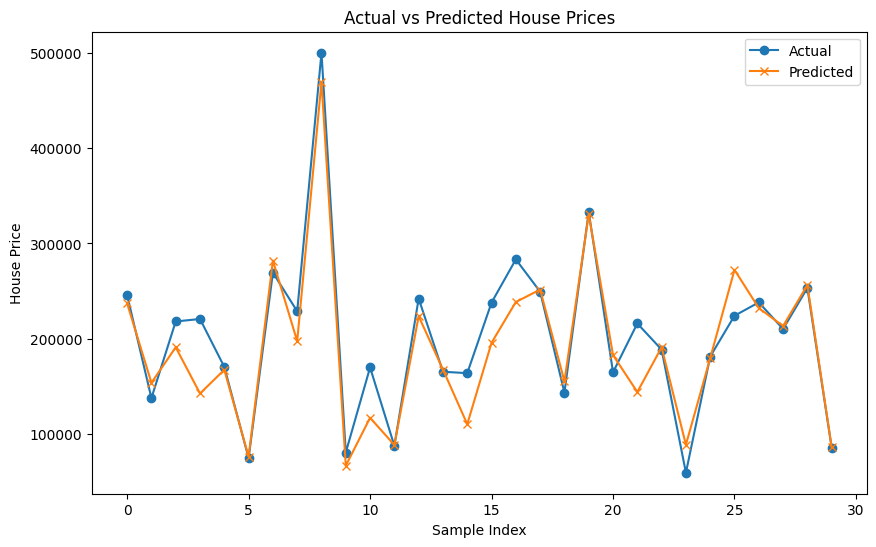

In [23]:
# Compare 10 actual values with 10 predicted values using the best model
predictions = best_forest.predict(x_test_scaled)

comparison_df = pd.DataFrame({'Actual': y_test[:30].values, 'Predicted': predictions[:30]})
print(comparison_df)

# Plot the comparison of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted House Prices')
plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.legend()
plt.show()